In [28]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import wcs
import os

In [29]:
!pwd
!ls

/Users/lockepatton/Desktop/2020-ASTR100/Notes/2020_02_06_Photometry
2020_02_06_Aperture_Photometry.ipynb
2020_02_06_Aperture_Photometry_The_Easier_Way.ipynb
data


# same file as we've worked with before - let's open it up

1337.2761 1091.3668


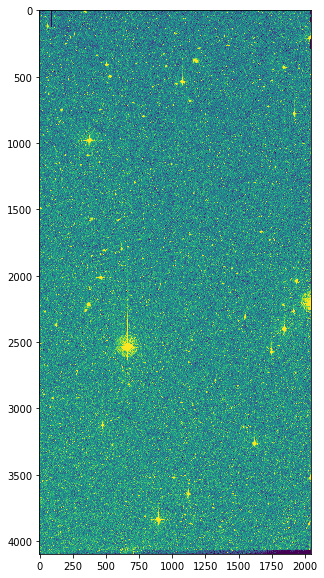

In [30]:
dir_ = '/Users/lockepatton/Desktop/2020-ASTR100/Notes/2020_02_04_Astropy_and_Fits/data/'
imageName = dir_+ 'PTF_201307021787_i_p_scie_t041723_u016616794_f02_p003486_c11.fits'
f = fits.open(imageName)
data = f[0].data  #This is the image array
header = f[0].header

mean = np.mean(data)
median = np.median(data)
sigma = np.std(data)

print(mean, sigma)

#plot the image with some reasonable scale
plt.figure(figsize=(10,10))
plt.imshow(data, vmin=median-.1*sigma, vmax=median+.1*sigma)
plt.show()

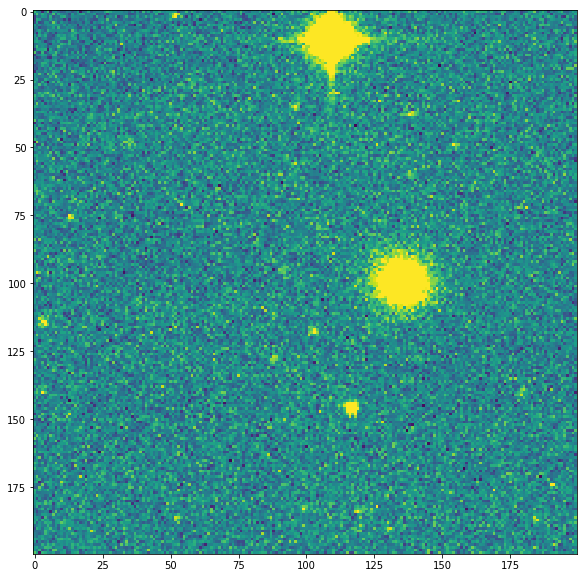

In [31]:
plt.figure(figsize=(10,10))
plt.imshow(data[400:600,400:600], vmin=median-.1*sigma, vmax=median+.1*sigma)
plt.show()

# zooming in on a star

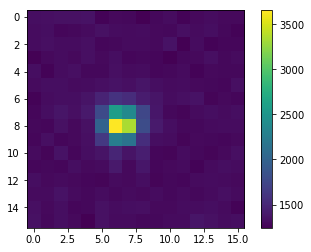

In [32]:
cx = 518
cy = 546
sx = 16
sy = 16

xmin, xmax = cx-sx//2, cx+sx//2
ymin, ymax = cy-sy//2, cy+sy//2

stamp = data[ymin:ymax,xmin:xmax]
plt.imshow(stamp)
plt.colorbar();

# first let's create a little function "disk"

It returns a 2D array that has 1's if it's within a defined radius and 0's otherwise.

In [33]:
def disc(sx, sy, rad):
    xbox = np.arange(sx*sy).reshape(sy,sx) % sx - (sx-1)/2
    ybox = np.arange(sx*sy).reshape(sy,sx) // sx - (sy-1)/2
    rbox = np.sqrt(xbox*xbox + ybox*ybox)
    return (rbox < rad).astype("int8")

# next let's do some aperture photometry!

We define an aperture "ap" using the disk function. This will be the region that we're looking to sum.

We'll also define a annulus "ann", which is created using the difference between two disc calls.

Using these combined, we can measure a background either mean or median of the annulus.

Our final value for the photometry is then the sum of the stamp within the aperture region minus the background times the number of pixels in the aperture.

In [34]:
def ap_phot(stamp, rad, skyrad):
    sy, sx = stamp.shape
    
    ap = disc(sx, sy, rad)
    ann = disc(sx, sy, skyrad[1]) - disc(sx, sy, skyrad[0])
    
#     background = np.sum(ann * stamp)/np.sum(ann) # mean background value
    background = np.mean(stamp[ann==1]) # mean background value
    background = np.median(stamp[ann==1]) # median background value
    
    print("sky background is:", background)        
    
    npix = np.sum(ap) # number of pixels in aperture
    phot = np.sum(stamp*ap) - background*npix
    phot = np.sum((stamp-background)*ap)
    return phot

In [35]:
disc(sx, sy, 4)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int8)

In [36]:
disc(sx, sy, 8)

array([[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]], dtype=int8)

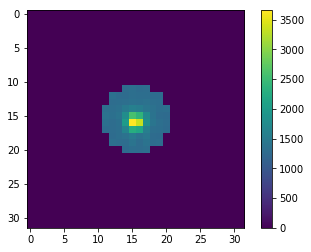

In [37]:
cx = 517
cy = 546
sx = 16*2
sy = 16*2

xmin, xmax = cx-sx//2, cx+sx//2
ymin, ymax = cy-sy//2, cy+sy//2

stamp = data[ymin:ymax,xmin:xmax]

rad = 5
skyrad = (8,10)
ap = disc(sx, sy, rad)
ann = disc(sx, sy, skyrad[1]) - disc(sx, sy, skyrad[0])

plt.imshow(stamp*ap)
plt.colorbar();

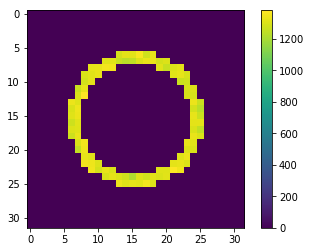

In [38]:
plt.imshow(stamp*ann)
plt.colorbar();

In [39]:
ap_phot(stamp, rad=rad, skyrad=skyrad)

sky background is: 1312.7478


13212.023

# for extra kicks

Let's take a look at how it changes as we change the inner radius!

sky background is: 1312.7478
sky background is: 1312.7478
sky background is: 1312.7478
sky background is: 1312.7478
sky background is: 1312.7478
sky background is: 1312.7478
sky background is: 1312.7478
sky background is: 1312.7478
sky background is: 1312.7478
sky background is: 1312.7478


Text(0, 0.5, 'Photometry value | pixels')

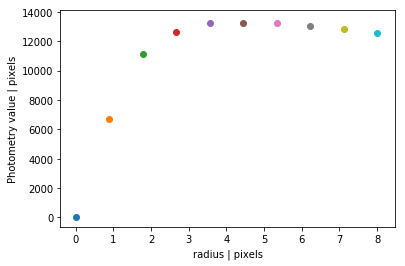

In [40]:
radii = np.linspace(0,skyrad[0],10)

for rad in radii:
    apvalue = ap_phot(stamp, rad=rad, skyrad=skyrad)
    plt.scatter(rad, apvalue)
    
plt.xlabel('radius | pixels')
plt.ylabel('Photometry value | pixels')

# continuing from last time - Feb 11 2019

####  an aside about persistence

In [41]:
a = np.arange(100).reshape(10,10)
b = a[2:6,2:6]
b[2,1]

43

In [42]:
b[2,1] = 212
print(b)
print(a)

[[ 22  23  24  25]
 [ 32  33  34  35]
 [ 42 212  44  45]
 [ 52  53  54  55]]
[[  0   1   2   3   4   5   6   7   8   9]
 [ 10  11  12  13  14  15  16  17  18  19]
 [ 20  21  22  23  24  25  26  27  28  29]
 [ 30  31  32  33  34  35  36  37  38  39]
 [ 40  41  42 212  44  45  46  47  48  49]
 [ 50  51  52  53  54  55  56  57  58  59]
 [ 60  61  62  63  64  65  66  67  68  69]
 [ 70  71  72  73  74  75  76  77  78  79]
 [ 80  81  82  83  84  85  86  87  88  89]
 [ 90  91  92  93  94  95  96  97  98  99]]


In [43]:
a = np.arange(100).reshape(10,10)
b = np.copy(a[2:6,2:6])
b[2,1] = 212
print(b)
print(a)

[[ 22  23  24  25]
 [ 32  33  34  35]
 [ 42 212  44  45]
 [ 52  53  54  55]]
[[ 0  1  2  3  4  5  6  7  8  9]
 [10 11 12 13 14 15 16 17 18 19]
 [20 21 22 23 24 25 26 27 28 29]
 [30 31 32 33 34 35 36 37 38 39]
 [40 41 42 43 44 45 46 47 48 49]
 [50 51 52 53 54 55 56 57 58 59]
 [60 61 62 63 64 65 66 67 68 69]
 [70 71 72 73 74 75 76 77 78 79]
 [80 81 82 83 84 85 86 87 88 89]
 [90 91 92 93 94 95 96 97 98 99]]


# now to find stars... the harder way

In [56]:
from astropy.convolution import convolve, Box1DKernel, Box2DKernel, Gaussian2DKernel

In [123]:
smoothimage = convolve(data, Box2DKernel(5))
im = np.copy(smoothimage[1000:1500,1000:1500])

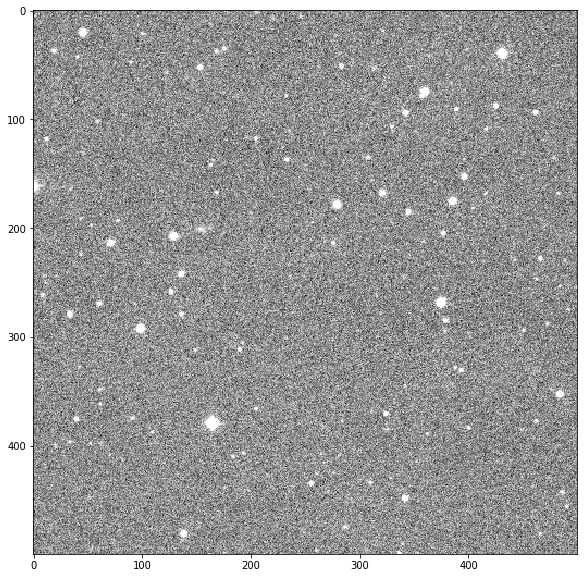

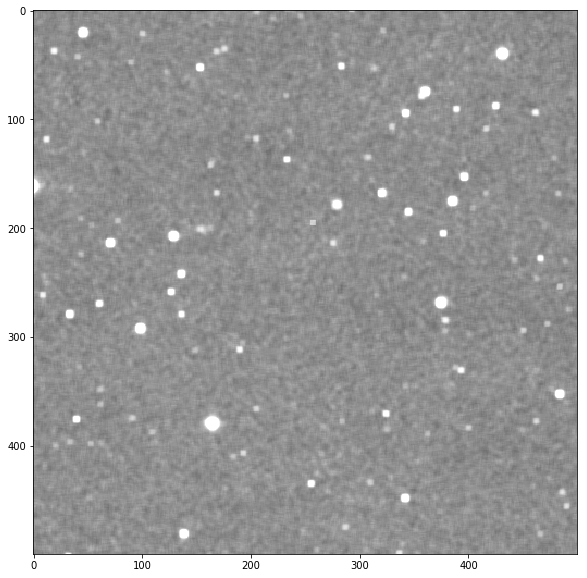

In [124]:
plt.figure(figsize=(10,10))
plt.imshow(data[1000:1500,1000:1500], cmap='Greys_r', vmin=median-.1*sigma, vmax=median+.1*sigma)
plt.show()
plt.figure(figsize=(10,10))
plt.imshow(im, cmap='Greys_r', vmin=median-.1*sigma, vmax=median+.1*sigma)
plt.show()

# let's find the maximum index of an array

In [125]:
foo = np.arange(12).reshape(3,4)
foo[1,2] = 111
print('foo:',foo)

indmax = np.argmax(foo)

print('indmax:',indmax)
print('foo.shape:',foo.shape)

xindmax, yindmax = np.unravel_index(indmax, foo.shape)
print('xindmax, yindmax:',xindmax, yindmax)

foo: [[  0   1   2   3]
 [  4   5 111   7]
 [  8   9  10  11]]
indmax: 6
foo.shape: (3, 4)
xindmax, yindmax: 1 2


In [126]:
def findstars(image, npad = 5, nstar = 10, blankval = -1):
    # initialize output arrays
    x = np.zeros(nstar).astype('int32')
    y = np.zeros(nstar).astype('int32')
    flux = np.zeros(nstar)
    
    # trim edges of images
    image[0:npad,:] = blankval
    image[:,0:npad] = blankval
    image[-npad-1:-1,:] = blankval
    image[:,-npad-1:-1] = blankval
    
    # loop over stars
    for i in np.arange(nstar):
        indmax = np.argmax(image)
        y[i], x[i] = np.unravel_index(indmax, image.shape)
        flux[i] =  image[y[i],x[i]]
        
        print(i, x[i], y[i], flux[i])
        
        image[y[i]-npad : y[i]+npad, x[i]-npad : x[i]+npad] = blankval

0 165 379 20100.8671875
1 431 40 9817.10546875
2 374 269 7517.3984375
3 98 292 4976.01806640625
4 129 207 4313.2626953125
5 385 175 3989.260009765625
6 46 20 3910.593505859375
7 360 74 3371.998779296875
8 71 214 2786.286865234375
9 484 352 2680.3828125


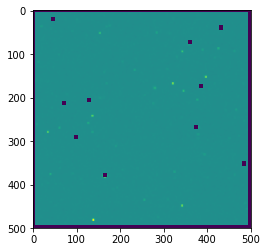

In [127]:
findstars(im)

plt.imshow(im)

# let's chat about photutils

In [128]:
from photutils import DAOStarFinder
from astropy.stats import mad_std

In [135]:
mad_std?

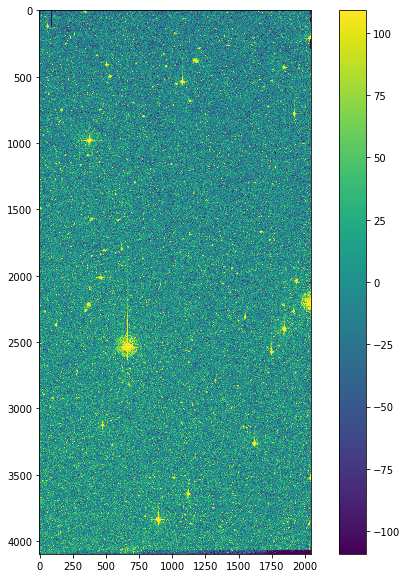

In [177]:
data = f[0].data

mean = np.mean(data)
median = np.median(data)
sigma = np.std(data)

# data -= median
data = data - median

plt.figure(figsize=(10,10))
# plt.imshow(data[100:140,100:140], vmin=-.1*sigma, vmax=+.1*sigma)
plt.imshow(data, vmin=-.1*sigma, vmax=+.1*sigma)
plt.colorbar()
plt.show()

In [178]:
DAOStarFinder?

In [179]:
bkg_sigma = mad_std(data)
daofind = DAOStarFinder(fwhm=4., threshold=3.*bkg_sigma)

In [180]:
sources = daofind(data)

In [181]:
sources

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
1,275.8507265139634,1.3253603219468424,0.4551790526400651,0.41774465933782245,0.643597927708782,25,0.0,44.0191650390625,1.3429653882887251,-0.3201620497862394
2,309.1498225928804,0.9185744378423345,0.6900817141946678,-0.22643572401512552,0.7172330142955059,25,0.0,37.7208251953125,1.043111358831957,-0.04582668656161287
3,885.531351563873,0.5828799140824383,0.476923912240182,0.07448357667232984,-0.17693223622471302,25,0.0,1833.978515625,27.10925488065324,-3.5827939520416017
4,1395.2213316681505,2.5916328999797553,0.25727913408652037,-0.1323173115456779,0.8994863358995931,25,0.0,1.4560546875,1.3745039931923713,-0.3453650147209861
5,1448.8740321015266,1.279321458042276,0.64324450262627,-0.1142287581865785,0.05395461836101342,25,0.0,145.645263671875,2.059462791095162,-0.7843848746009281
6,1945.9686707925305,0.7607615634377038,0.37764937885325006,-0.009250766046730419,0.824414465854687,25,0.0,28.0413818359375,1.4005500256027332,-0.3657465645041239
7,78.50829383699673,2.3737527272773495,0.3608311703892309,-0.39487223092021606,-0.5586905939257311,25,0.0,0.355224609375,1.0035339930291365,-0.003830220172708723
8,105.23617854299205,2.8413963235644353,0.2899621014969375,-0.04092880574911812,0.07288117617319838,25,0.0,-3.2901611328125,1.0134044637352393,-0.014457032231493784
9,145.09697167603565,2.194005598547593,0.5681337624421967,-0.5660967448081116,-0.7857583436610691,25,0.0,57.2249755859375,1.2869866475557366,-0.27393510284188144


In [182]:
sources.keys()

['id',
 'xcentroid',
 'ycentroid',
 'sharpness',
 'roundness1',
 'roundness2',
 'npix',
 'sky',
 'peak',
 'flux',
 'mag']

In [183]:
sources['roundness2'][1]

0.7172330142955059

In [184]:
from photutils import aperture_photometry, CircularAperture

In [185]:
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))

apertures = CircularAperture(positions, r=4.)

phot_table = aperture_photometry(data, apertures)
phot_table

id,xcenter,ycenter,aperture_sum
,pix,pix,
int64,float64,float64,float64
1,275.8507265139634,1.3253603219468424,-493.84361053017903
2,309.1498225928804,0.9185744378423345,-1485.5666580818959
3,885.531351563873,0.5828799140824383,11348.493757073666
4,1395.2213316681505,2.5916328999797553,-1411.9781172520168
5,1448.8740321015266,1.279321458042276,-34.24390738853131
6,1945.9686707925305,0.7607615634377038,-1144.440133701481
7,78.50829383699673,2.3737527272773495,-1365.4935282133897
8,105.23617854299205,2.8413963235644353,-1574.9038147052204


In [188]:
phot_table[phot_table['aperture_sum']>0]

id,xcenter,ycenter,aperture_sum
,pix,pix,
int64,float64,float64,float64
3,885.531351563873,0.5828799140824383,11348.493757073666
28,315.4329775496304,3.113045165909469,495.86760416100117
35,680.1978301044248,5.8358766635892225,30060.69837033578
40,1348.7628020958223,8.99970775568889,330.98218880966016
42,513.5103301249466,9.823786025771378,512.4431985259266
44,341.70228405617974,10.12828514627104,18231.54335538944
45,346.5398918633736,10.812083563148308,31105.395013321744
47,843.5271612887409,11.212144215375105,671.9348445447717


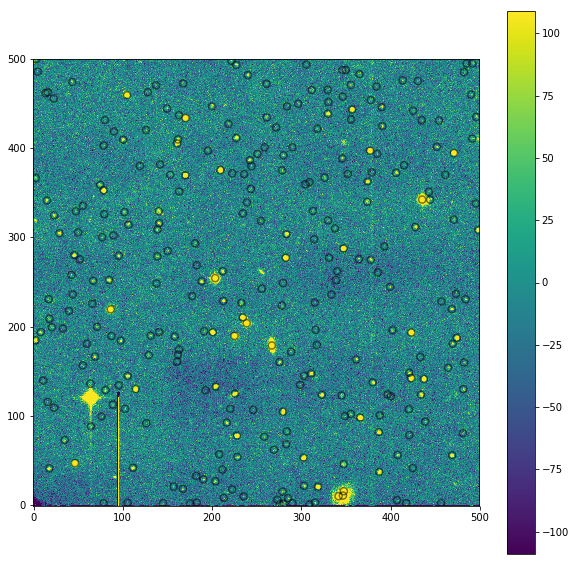

In [187]:
plt.figure(figsize=(10,10))
plt.imshow(data[:500,:500], cmap='viridis', origin='lower', vmin=-.1*sigma, vmax=+.1*sigma)
plt.colorbar()
apertures.plot(color='black', lw=1.5, alpha=0.5)

# An fun aside about how CCDs read out!

http://spiff.rit.edu/classes/ast613/lectures/ccds_kids/ccds_kids.html

https://hamamatsu.magnet.fsu.edu/articles/moscapacitor.html


